### 0. Importing modules and data

In [71]:
%matplotlib widget
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump
from edastatmil_milser import edas_tatmil as EDA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score

In [72]:

raw_df = pd.read_csv('../data/raw/Housing.csv')
raw_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


We will keep only the columns that interest us

In [73]:
columns = ['Latitude','Longitude','MedInc']
df = raw_df.loc[:,columns]
df.head()

,Latitude,Longitude,MedInc
0,37.88,-122.23,8.3252
1,37.86,-122.22,8.3014
2,37.85,-122.24,7.2574
3,37.85,-122.25,5.6431
4,37.85,-122.25,3.8462


In [74]:
c ,n =EDA.explore(df)

Rows: 20640
Columns: 3
+-----------+----------------+------------+-----------+---------------+
|           | Non-Null Count | Null Count | Data Type | Data Category |
+-----------+----------------+------------+-----------+---------------+
| Latitude  |     20640      |     0      |  float64  |   Numerical   |
| Longitude |     20640      |     0      |  float64  |   Numerical   |
|  MedInc   |     20640      |     0      |  float64  |   Numerical   |
+-----------+----------------+------------+-----------+---------------+


Let normalize the variable 'MedInc' in order to make a better graphical representation

In [75]:
scaler = MinMaxScaler()
df['MedInc_scaled'] = scaler.fit_transform(df[['MedInc']])

### 1.Split dataset

In [76]:
columns2 = ['Latitude','Longitude','MedInc_scaled']
df_norm = df.loc[:,columns2]

In [77]:
X_trainClust, X_testClust = train_test_split(df_norm, test_size=0.2, random_state=42)

In [78]:
X_trainClust.to_csv('../data/processed/Clustering/X_train.csv', index=False)
X_testClust.to_csv('../data/processed/Clustering/X_test.csv', index=False)

In [79]:
X_trainClust.head()

,Latitude,Longitude,MedInc_scaled
14196,32.71,-117.03,0.190322
8267,33.77,-118.16,0.228452
17445,34.66,-120.48,0.252162
14265,32.69,-117.11,0.099488
2271,36.78,-119.80,0.210638


### 2.K-means

In [80]:
clustering = KMeans(n_clusters=6,random_state=42)
clustering.fit(X_trainClust)

KMeans(n_clusters=6, random_state=42)

In [81]:
labels = clustering.labels_
centroids = clustering.cluster_centers_

print(labels)

[1 1 3 ... 1 0 0]


In [82]:
dump(clustering, open("../data/processed/Models/K-Means_default_42.sav", "wb"))

It is not necessary to categorize it, the labels are already factorized.

In [83]:
X_trainClust['cluster'] = labels

#### 2.1 Visualization

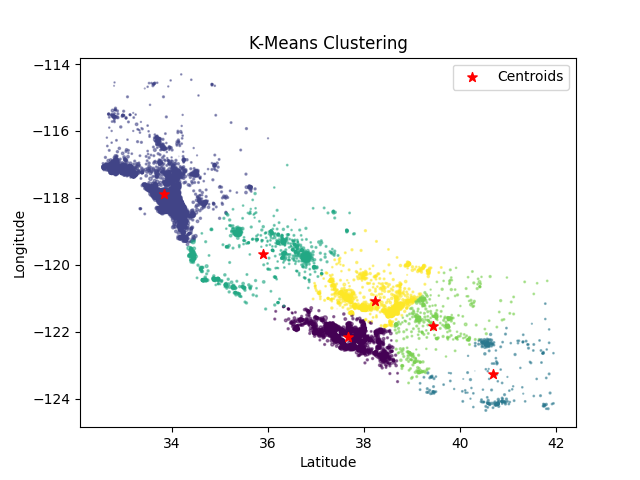

In [84]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

ax1.scatter(X_trainClust['Latitude'], X_trainClust['Longitude'], s=X_trainClust['MedInc_scaled']*10, c=labels, cmap='viridis', alpha=0.5)
ax1.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=50, c='red', label='Centroids')
ax1.set_title('K-Means Clustering')
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Longitude')
ax1.legend()


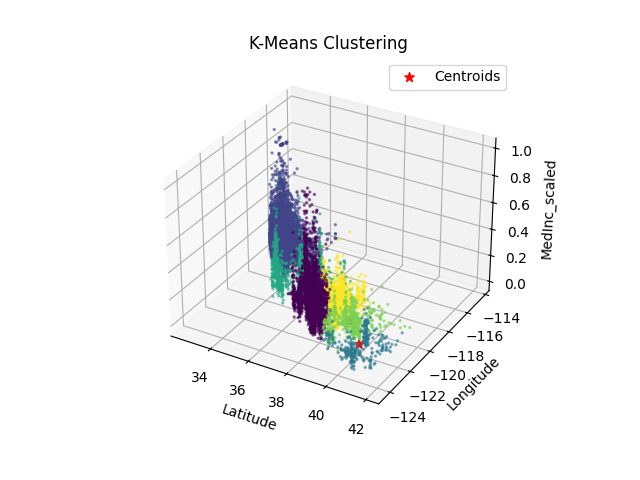

In [85]:
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')

ax2.scatter(X_trainClust['Latitude'], X_trainClust['Longitude'], X_trainClust['MedInc_scaled'], c=labels, cmap='viridis', alpha=0.5, s=2)
ax2.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', s=50, c='red', label='Centroids')

ax2.set_title('K-Means Clustering')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Longitude')
ax2.set_zlabel('MedInc_scaled')
ax2.legend()

#### 2.2 Prediction

In [86]:
pred =  clustering.predict(X_testClust)
X_testClust['cluster'] = pred

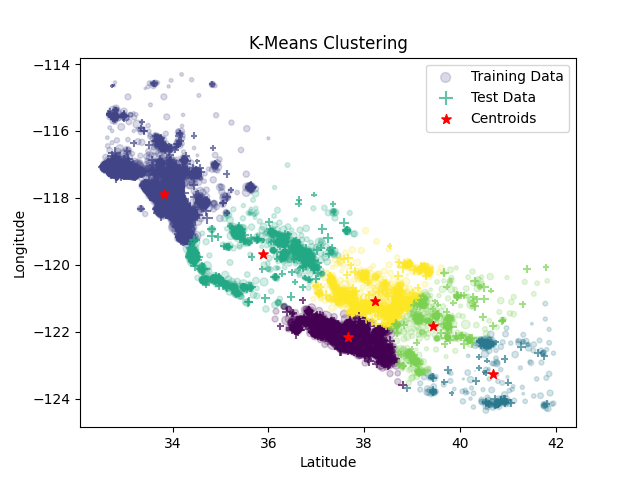

In [87]:
fig3 = plt.figure()
ax3 = fig3.add_subplot(111)

ax3.scatter(X_trainClust['Latitude'], X_trainClust['Longitude'], s=X_trainClust['MedInc_scaled']*100, c=labels, cmap='viridis', alpha=0.2, marker='o', label='Training Data')
ax3.scatter(X_testClust['Latitude'], X_testClust['Longitude'], s=X_testClust['MedInc_scaled']*200, c=pred, cmap='viridis', alpha=0.7, marker='+', label='Test Data')
ax3.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=50, c='red', label='Centroids')
ax3.set_title('K-Means Clustering')
ax3.set_xlabel('Latitude')
ax3.set_ylabel('Longitude')
ax3.legend()

It seems that the prediction is correct; the new points are in the correct clusters.

### 3. Decision Tree

In [88]:
all_Clustdf = pd.concat([X_trainClust, X_testClust])
all_Clustdf.to_csv('../data/processed/HousingCategorized.csv', index=False)

In [89]:
all_Clustdf.columns

Index(['Latitude', 'Longitude', 'MedInc_scaled', 'cluster'], dtype='object')

In [90]:
target = 'cluster'
predictors = ['Latitude', 'Longitude', 'MedInc_scaled']
EDA.splitter('../data/processed/', predictors, target)

{'HousingCategorized_Xtrain':        Latitude  Longitude  MedInc_scaled
 7061      34.44    -119.75       0.092640
 14689     36.61    -121.83       0.189970
 17323     34.02    -118.05       0.112074
 10056     34.13    -117.37       0.127288
 15750     33.96    -118.31       0.274907
 ...         ...        ...            ...
 11284     33.79    -118.29       0.196052
 11964     38.04    -121.34       0.214369
 5390      32.74    -116.99       0.240307
 860       33.84    -117.87       0.276638
 15795     33.91    -118.32       0.255176
 
 [14448 rows x 3 columns],
 'HousingCategorized_Xtest':        Latitude  Longitude  MedInc_scaled
 20046     36.80    -119.73       0.224680
 3024      36.21    -119.37       0.065213
 15663     38.65    -121.26       0.286100
 20484     34.08    -118.68       0.240928
 9814      40.77    -121.86       0.138143
 ...         ...        ...            ...
 17505     34.48    -117.20       0.186556
 13512     36.95    -120.05       0.120881
 10842     

In [91]:
X_trainDS = pd.read_csv('../data/processed/SplitData/HousingCategorized_Xtrain.csv')
y_trainDS = pd.read_csv('../data/processed/SplitData/HousingCategorized_ytrain.csv')
X_testDS = pd.read_csv('../data/processed/SplitData/HousingCategorized_Xtest.csv')
y_testDS = pd.read_csv('../data/processed/SplitData/HousingCategorized_ytest.csv')

In [92]:
DT_model = DecisionTreeClassifier(random_state = 42)
DT_model.fit(X_trainDS, y_trainDS)
dump(DT_model, open("../data/processed/Models/Decision_tree_regressor_default_42.sav", "wb"))

#### 3.1 Prediction

In [93]:
DT_ypred = DT_model.predict(X_testDS)
DT_Acc = accuracy_score(y_testDS, DT_ypred)
print('Accuracy with all data:',DT_Acc)

Accuracy with all data: 0.997093023255814
